In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from dotenv import load_dotenv
from collections import Counter

# NLP and Text Processing
import nltk
from nltk import word_tokenize, pos_tag
from nltk.corpus import cmudict
from textblob import TextBlob
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import textstat
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

# Scikit-learn
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, accuracy_score, classification_report

# Local
from classes.song import Song
from classes.spotify_manager import SpotifyManager
from classes.lyrics_manager import LyricsManager
from classes.utils import gather_data_from_folders, variance_based_empath_cleaning, winsorize_series
from classes.stats import BootstrapEvaluator
from classes.model_pipeline import OptimalClassificationPipeline, OptimalRegressionPipeline

from classes.eda import correlation_heatmap, plot_dendrogram, plot_network, plot_tsne, plot_top_features_per_genre_heatmap, plot_feature_max_by_genre_heatmap, analyze_genre_features

import warnings
from empath import Empath
warnings.simplefilter('ignore')
load_dotenv();

In [3]:
ROOT_PATH = os.path.realpath(os.path.abspath(""))

# Loading the data

In [4]:
df = pd.read_pickle(os.path.join('datasets', "new_data.pkl"))
print(f"Loaded {df.shape[0]} songs")
df.head()

Loaded 3621 songs


,id,title,artist,album_art_url,popularity,explicit,album_release_year,duration_ms,genres,lyrics,...,w2v_91,w2v_92,w2v_93,w2v_94,w2v_95,w2v_96,w2v_97,w2v_98,w2v_99,genre
0,6YDDrg8llsRtAgLlIROzZc,put your head on my shoulder,paul anka,https://i.scdn.co/image/ab67616d0000b2737f16eb...,68.0,0,1959,158906,"['genre:pop', 'adult', 'standards', 'canadian'...",Put your head on my shoulder\nHold me in your ...,...,-0.003423,0.016568,0.002319,0.007630,-0.003030,0.009287,0.006670,0.003556,0.003469,pop
1,5zvOXJrzzUlvXwyuwZ0toZ,oh! carol,neil sedaka,https://i.scdn.co/image/ab67616d0000b2733843b4...,58.0,0,1959,136562,"['genre:pop', 'adult', 'standards', 'brill', '...","Oh! Carol\nI am but a fool\nDarling, I love yo...",...,-0.004206,-0.010597,0.007079,-0.003365,0.015292,-0.004908,0.000558,-0.006474,0.000418,pop
2,0QGwOFQChzflLAmPq5NwKo,a teenager in love,dion & the belmonts,https://i.scdn.co/image/ab67616d0000b2737a6091...,61.0,0,1959,158253,"['genre:pop', 'brill', 'building', 'pop', 'doo...",Each time we have a quarrel\nIt almost breaks ...,...,-0.005288,-0.016978,0.001973,0.016645,0.005722,-0.000172,0.000788,-0.002016,0.009753,pop
3,0hjYuU2Z9jcKvOl39oUpeE,diana,paul anka,https://i.scdn.co/image/ab67616d0000b2737f16eb...,56.0,0,1959,147760,"['genre:pop', 'adult', 'standards', 'canadian'...","I'm so young and you're so old\nThis, my darli...",...,-0.002524,-0.011046,-0.001598,-0.004006,0.001692,0.002618,0.004807,-0.001807,-0.000070,pop
4,1mdfrHeZzxjz0FJ4BKRuxS,puppy love,paul anka,https://i.scdn.co/image/ab67616d0000b2737f16eb...,57.0,0,1959,161533,"['genre:pop', 'adult', 'standards', 'canadian'...",And they called it puppy love\nOh I guess they...,...,-0.005602,0.010182,-0.006879,-0.001400,-0.001735,-0.001136,-0.004035,0.016890,0.001792,pop


In [5]:
spotify_features = ['popularity', 'explicit',
       'album_release_year', 'duration_ms', 'danceability', 'energy', 'key',
       'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness',
       'liveness', 'valence', 'tempo', 'time_signature']

lyrics_features = ['unique_word_count',
       'sentiment_polarity', 'sentiment_subjectivity', 'noun_ratio',
       'verb_ratio', 'vader_compound', 'repetition_count', 'language', 'genre',
       'lexical_richness', 'semantic_depth', 'syntactic_complexity',
       'rhyme_density', 'sentiment_variability', 'linguistic_uniqueness',
       'flesch_reading_ease', 'gunning_fog', 'dale_chall', 'type_token_ratio', 'word_count']

tfidf_features = [ f for f in df.columns if f.startswith("tfidf_") ]

w2v_features = [ f for f in df.columns if f.startswith("w2v") ]

empath_features = [ f for f in df.columns if f.startswith("empath") ]

audio_extracted_features = ['mfcc_1', 'mfcc_2',
       'mfcc_3', 'mfcc_4', 'mfcc_5', 'mfcc_6', 'mfcc_7', 'mfcc_8', 'mfcc_9',
       'mfcc_10', 'mfcc_11', 'mfcc_12', 'mfcc_13', 'chroma_1', 'chroma_2',
       'chroma_3', 'chroma_4', 'chroma_5', 'chroma_6', 'chroma_7', 'chroma_8',
       'chroma_9', 'chroma_10', 'chroma_11', 'chroma_12',
       'spectral_contrast_1', 'spectral_contrast_2', 'spectral_contrast_3',
       'spectral_contrast_4', 'spectral_contrast_5', 'spectral_contrast_6',
       'spectral_contrast_7', 'tempo_extracted', 'zcr']

In [6]:
empath_features = variance_based_empath_cleaning(df)

INFO: Total empath features: 194
INFO: Low-variance features to remove: 175


# 1. Correlation Heatmap of most correlated features
Displays correlation heatmap between features that have correlation > 0.6 with at least one other feature.

Spotify audio features show high level of correlation between each other, especially:
* strong positive correlation of 0.74 between energy and  loudness
* strong negative correlation of -0.61 between energy and acousticness
* release year correlates with loudness and energy, indicating possible existence of a trend in modern music to shift to more energetic and intense style
* danceability correlates strongly with valence, which means songs that are perceived as positive are usually more danceable

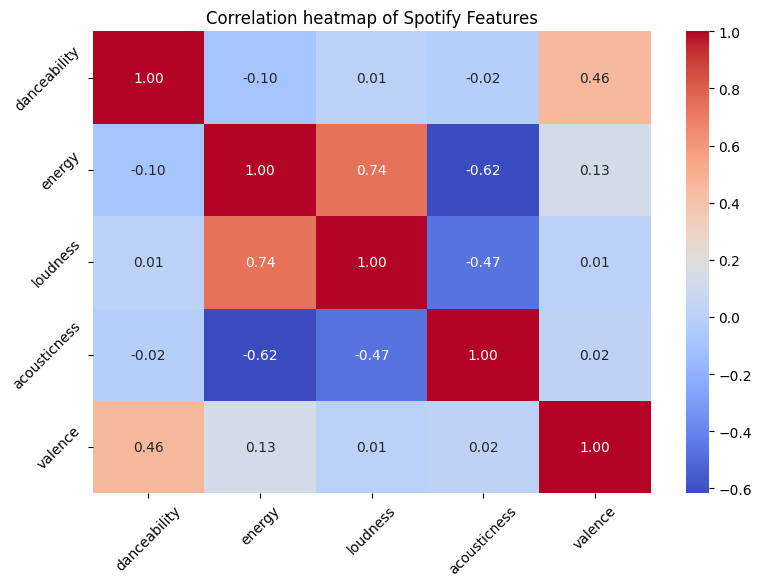

In [7]:
fig =  correlation_heatmap(df, spotify_features, title='Correlation heatmap of Spotify Features', threshold=0.45)
fig.set_figwidth(9)
fig.set_figheight(6)
fig.axes[0].tick_params(axis='y', rotation=45)
fig.axes[0].tick_params(axis='x', rotation=45)
fig.savefig(os.path.join(ROOT_PATH, 'document', 'img', 'corr_heatmap_spotify_features.png'), bbox_inches='tight')
fig

When it comes to correlations between lyrical features we observe high correlation between flesch reading ease, gunning fog a nd dale chall, which all attempt to quantify lyrrical complexity of the text. Apart from that lyrical uniqueness has relatively high correlation with noun ratio and verb ratio.

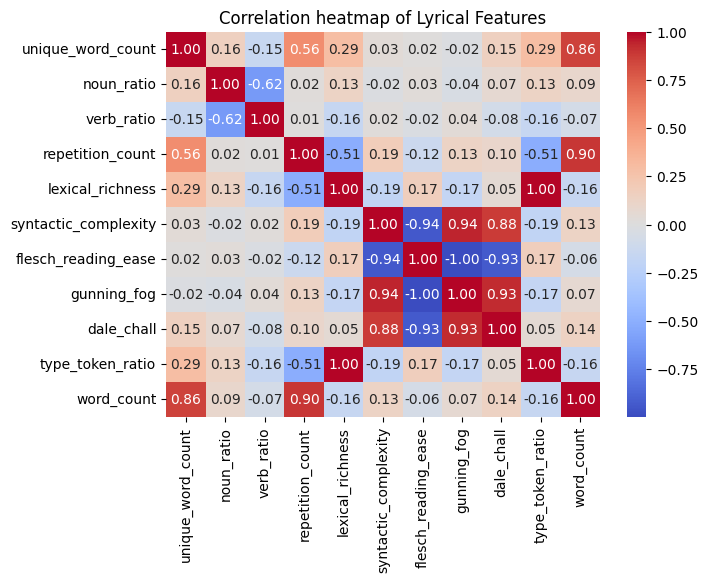

In [8]:
fig =  correlation_heatmap(df, lyrics_features, title='Correlation heatmap of Lyrical Features')
fig.set_figwidth(7)
fig.set_figheight(5)
fig.savefig(os.path.join(ROOT_PATH, 'document', 'img', 'corr_heatmap_lyrical.png'), bbox_inches='tight')
fig

When it comes to features extracted from audio files we see that often features of similar kind display higher correlation with each other, ex. correlations between different MFCC.

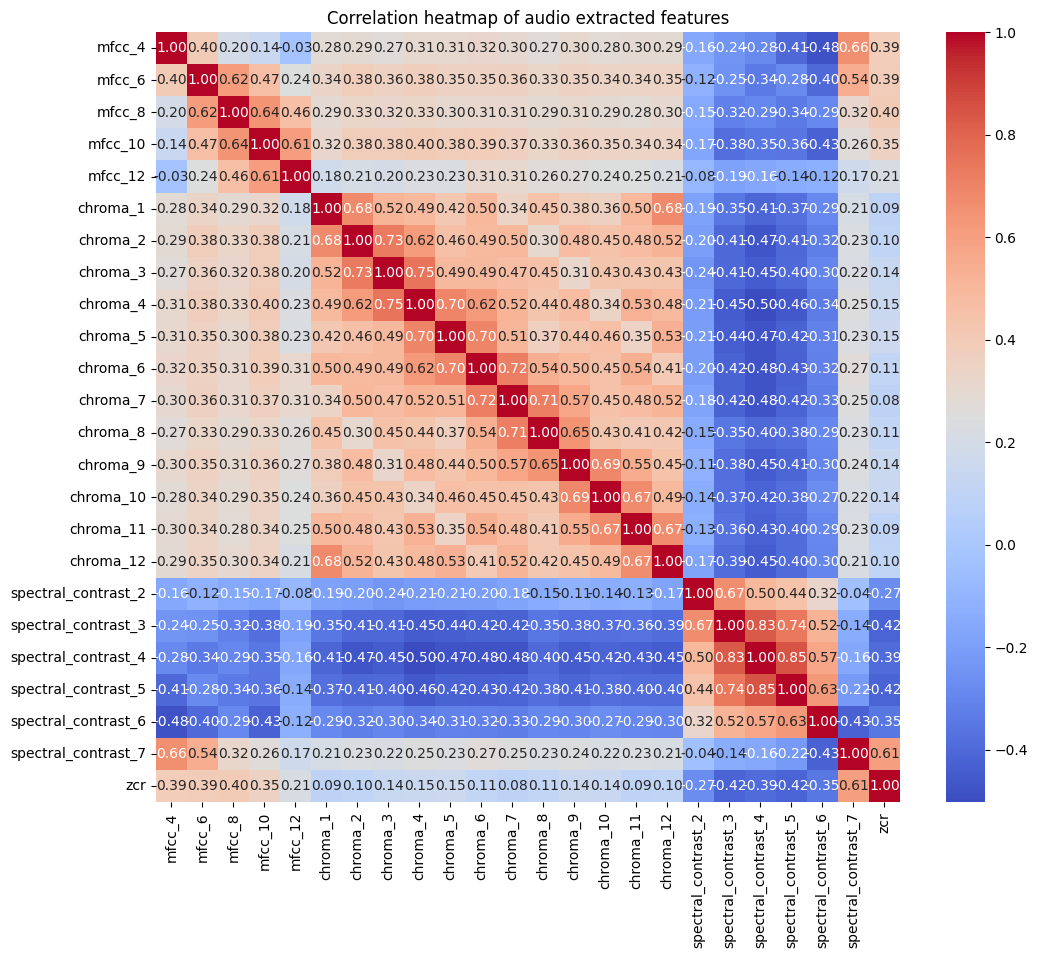

In [9]:
fig = correlation_heatmap(df, audio_extracted_features, title='Correlation heatmap of audio extracted features')
fig.set_figwidth(12)
fig.set_figheight(10)
fig.savefig(os.path.join(ROOT_PATH, 'document', 'img', 'corr_heatmap_audio.png'), bbox_inches='tight')
fig

When it comes to correlations in empath features, we see very logical and  intuitive relationships between different categories, for example potitive empotion correlates positively with love, optimism, affection.

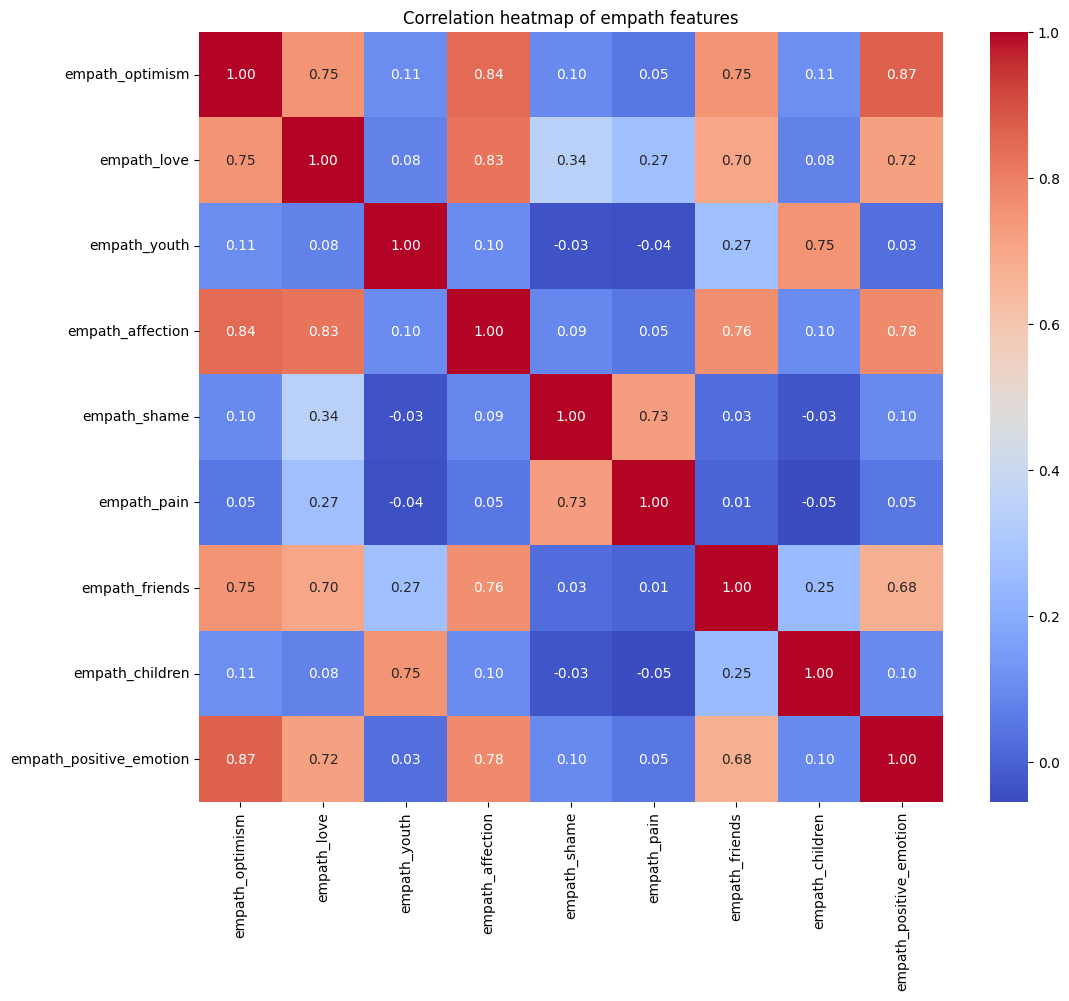

In [10]:
fig = correlation_heatmap(df, empath_features, title='Correlation heatmap of empath features', threshold=0.7)
fig.set_figwidth(12)
fig.set_figheight(10)
fig.savefig(os.path.join(ROOT_PATH, 'document', 'img', 'corr_heatmap_empath.png'), bbox_inches='tight')
fig

# 2. Hierarchical Clustering (Dendrogram)
Purpose:
Hierarchical clustering groups similar features based on their pairwise correlations, visualized using a dendrogram. This technique helps in clustering features into groups that are highly correlated, reducing dimensionality or simplifying feature analysis.

How It Works:

The dendrogram is built using agglomerative clustering, where each feature starts in its own cluster, and the most similar clusters are merged at each step. This continues until all features are grouped into a single cluster.


This method allowed to identify clusters of features that are strongly correlated. 

When it comes to spotify features we notice that the relationships between certain features and we can distinguish subsets of features that are, to some extent, correlated.

We see there's a relationship between danceability, valence, instrumentalness and duration.

Similarily we see strong relationship between energy, loudness, acousticness and release year.

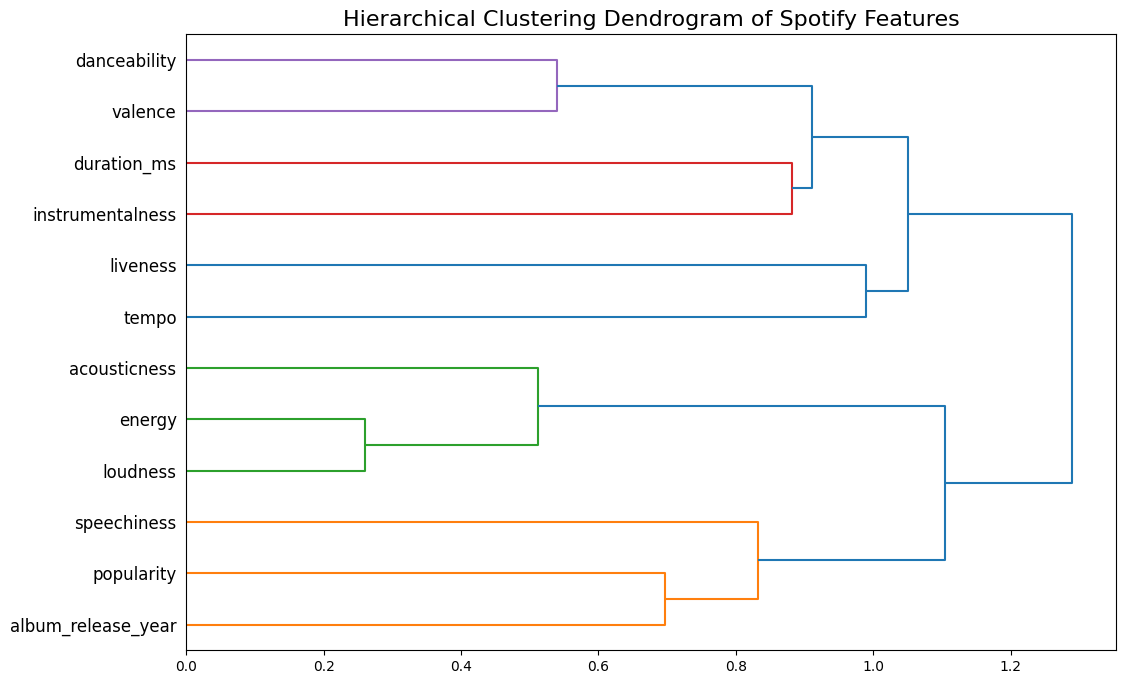

In [11]:
fig = plot_dendrogram(df, spotify_features, title='Spotify Features')
fig.set_figwidth(12)
fig.set_figheight(8)
fig.savefig(os.path.join(ROOT_PATH, 'document', 'img', 'dendrogram_spotify_features.png'), bbox_inches='tight')
fig

With lyrical features three main groups can be distinguished:
* Lyrical Complexity features
* Lexical features
* Sentiment-related features

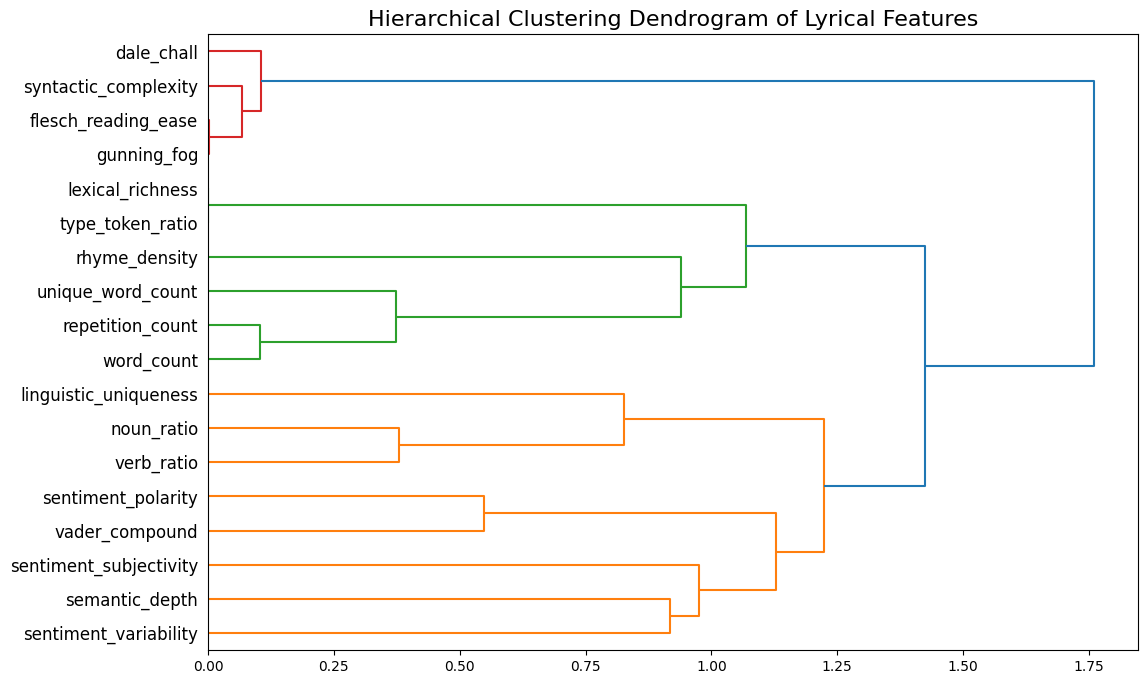

In [12]:
fig = plot_dendrogram(df, lyrics_features, title='Lyrical Features')
fig.set_figwidth(12)
fig.set_figheight(8)
fig.savefig(os.path.join(ROOT_PATH, 'document', 'img', 'dendrogram_lyrical.png'), bbox_inches='tight')
fig

With audio extracted features for the most part we see that mfccs, spectral contrasts and chromas seem to be holding together showing  greatest similarity between each other and much smaller with other types.

Mfcc_2 seems to be  in rlatively high correlation with zero crossing rate.

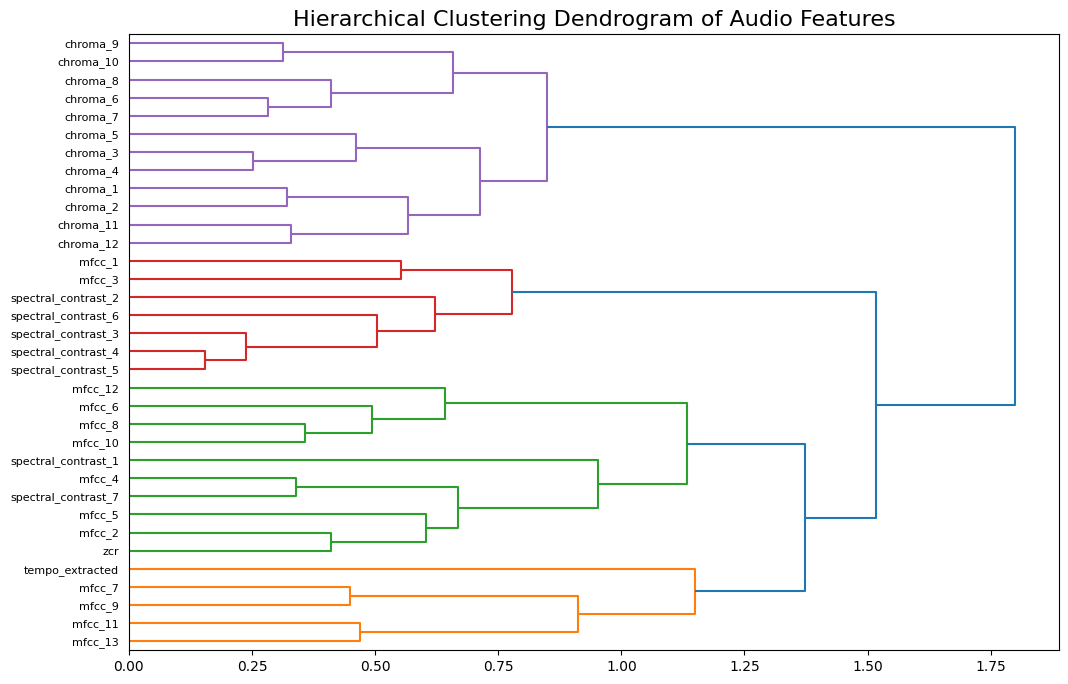

In [13]:
fig = plot_dendrogram(df, audio_extracted_features, title='Audio Features')
fig.set_figwidth(12)
fig.set_figheight(8)
fig.savefig(os.path.join(ROOT_PATH, 'document', 'img', 'dendrogram_audio.png'), bbox_inches='tight')
fig

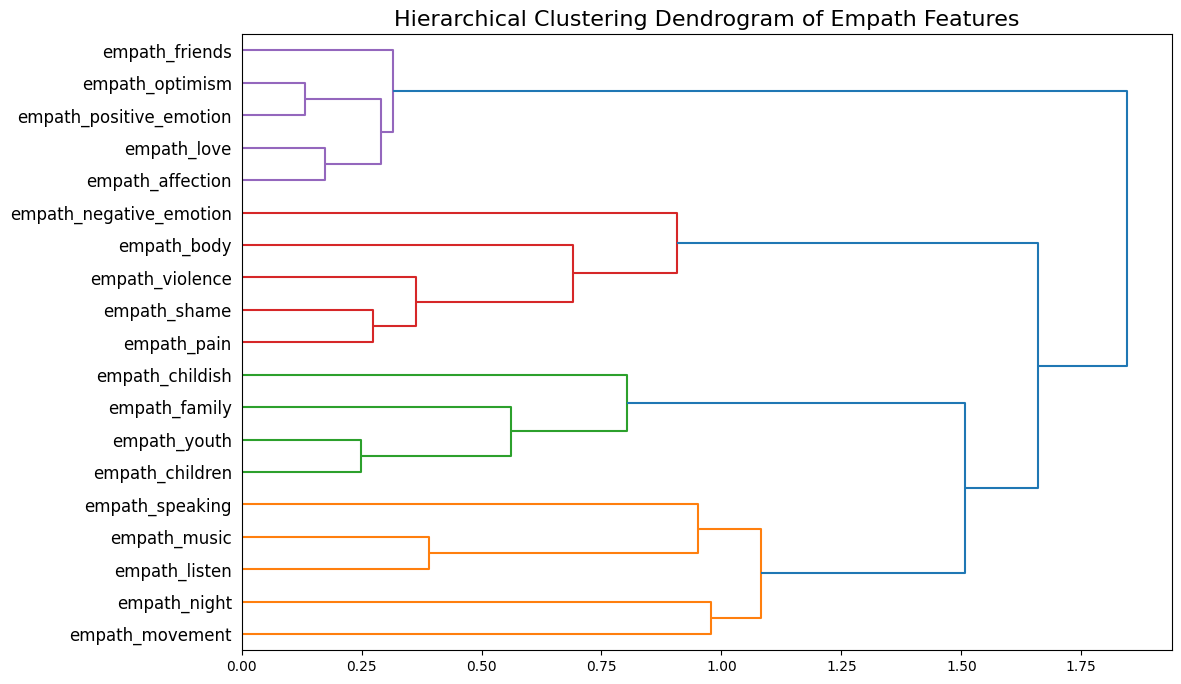

In [14]:
fig = plot_dendrogram(df, empath_features, title='Empath Features')
fig.set_figwidth(12)
fig.set_figheight(8)
fig.savefig(os.path.join(ROOT_PATH, 'document', 'img', 'dendrogram_empath.png'), bbox_inches='tight')
fig

# 3. Network Graph of Highly Correlated Features
Purpose:
This method visualizes the relationships between highly correlated features as a network graph. It helps in understanding how features are interconnected.

How It Works:

You constructed a graph where each node represents a feature, and edges between nodes represent strong correlations (above a threshold, e.g., 0.7).
The spring layout was used to visualize the network, where highly connected nodes are pulled together, and less connected nodes are pushed apart.
Conclusion:
The network graph gives a visual summary of how features relate to each other, with clusters of nodes indicating groups of correlated features.

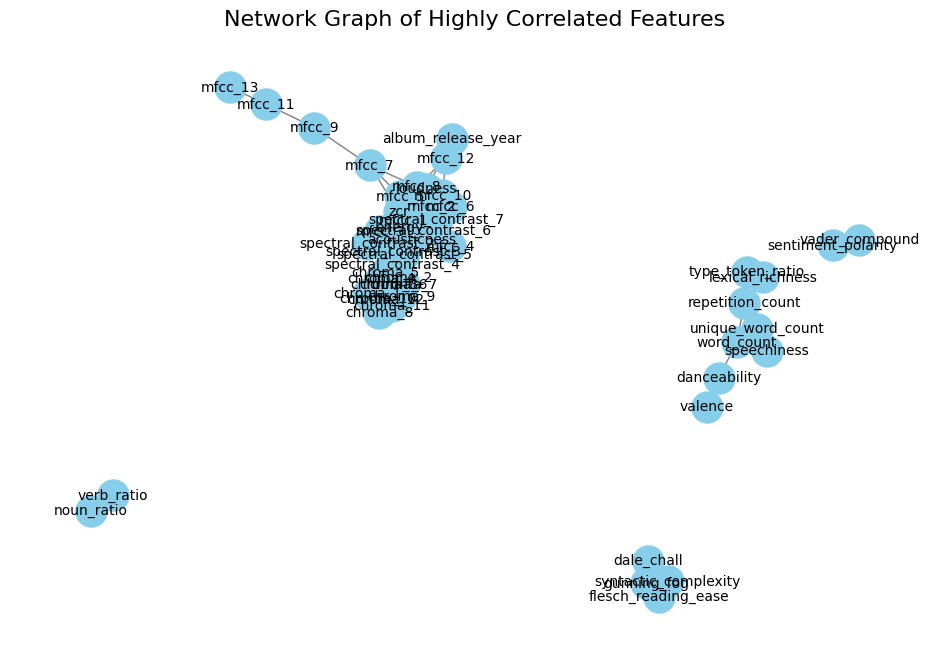

In [85]:
fig = plot_network(df, lyrics_features + spotify_features + audio_extracted_features)
fig.set_figwidth(12)
fig.set_figheight(8)
fig

With empath, since its goal is to be interpretable, we see that the connections between categories display frequent contextual relations between the topics to which the categories refer to, ex. music and listen categories are very highly related and have little relation with the rest.

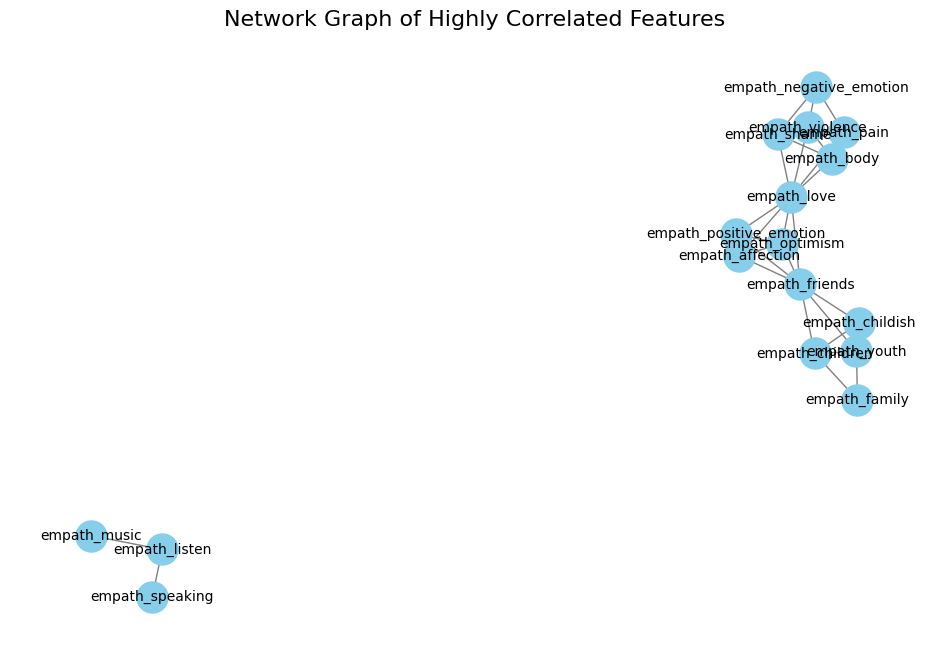

In [86]:
fig = plot_network(df, empath_features, threshold=0.2)
fig.set_figwidth(12)
fig.set_figheight(8)
fig

# 4. t-SNE (t-Distributed Stochastic Neighbor Embedding)
Purpose:
t-SNE is used to visualize high-dimensional data in a 2D or 3D space while preserving local structure (similarities between points). It is particularly useful for visualizing clusters in data.

How It Works:

t-SNE reduces the dimensionality of data by modeling pairwise similarities between points in high-dimensional space and attempts to preserve these similarities in the low-dimensional projection.
t-SNE uses a probability distribution to calculate the similarity between points, with closer points in the original space being more likely to remain close in the reduced space.
It is useful for visualizing non-linear relationships in data, unlike PCA, which focuses on linear variance.
Conclusion:
In your t-SNE plot, you likely saw clusters of points corresponding to groups of songs that are similar in terms of their features. Well-separated clusters suggest that the songs in different groups are quite distinct in terms of musical characteristics or lyrics.



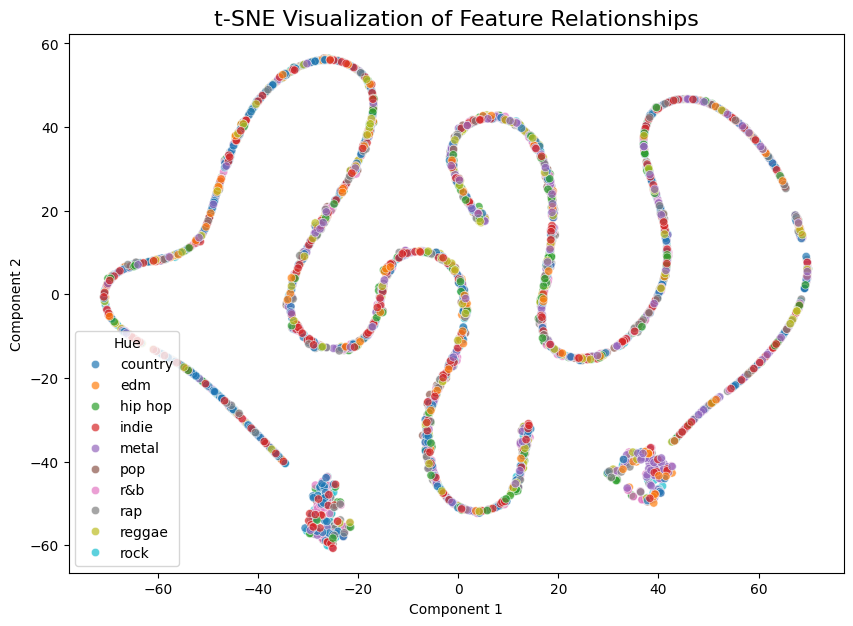

In [25]:
plot_tsne(df, lyrics_features + audio_extracted_features + tfidf_features + spotify_features + w2v_features + empath_features, hue='genre')

It shows that with the features that currently are at our disposal we are able to clearly split songs into very distinct groups, however those groups don't seem to be in much accord with genres, which might suggest that there is a better alternative to genres that could help us to divide songs in a better way.

# 5. Genres

This simple rrelationship dendrogram between genres shows us how similar different genres are. We can identify the most similar genres as:
* R&B and Hip Hop
* Reggae & Indie
* Pop & Country
* Metal is by far the furthest from the other genres

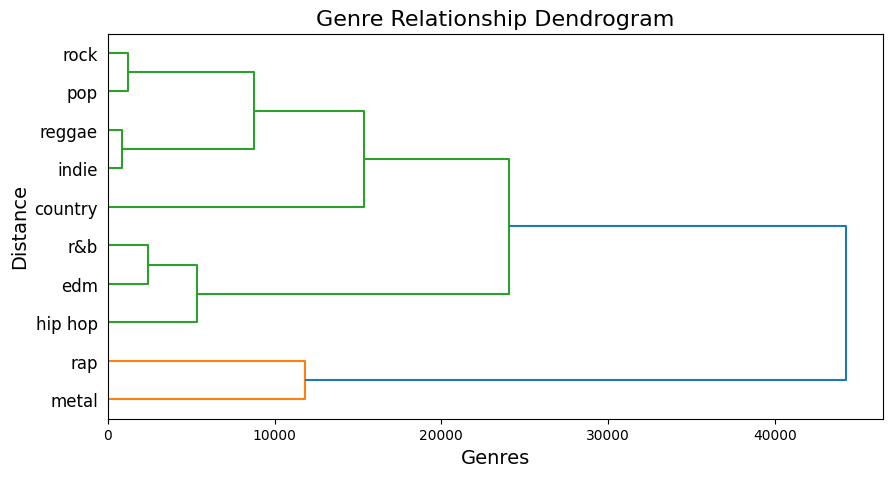

In [87]:
from scipy.cluster.hierarchy import linkage, dendrogram
import matplotlib.pyplot as plt

features = lyrics_features + audio_extracted_features + tfidf_features + spotify_features + w2v_features + empath_features
num_df = df[features].dropna().select_dtypes(include=[np.number])
num_df = pd.concat([num_df, df.genre], axis=1)
genre_features = num_df.groupby("genre").mean()
linkage_matrix = linkage(genre_features, method='ward')

plt.figure(figsize=(10, 5))  # Adjust width and height
dendrogram(linkage_matrix, labels=genre_features.index,orientation='right')
plt.title("Genre Relationship Dendrogram", fontsize=16)
plt.xlabel("Genres", fontsize=14)
plt.ylabel("Distance", fontsize=14)
plt.show()


When we check the relationship taking into account only the features extracted from lyrics and audio, we see relationships that align more with how  the genres are associated in popculture, for example rap and  hip hop are now highly similar. It can also be noticed that they are very distinct from other genres.

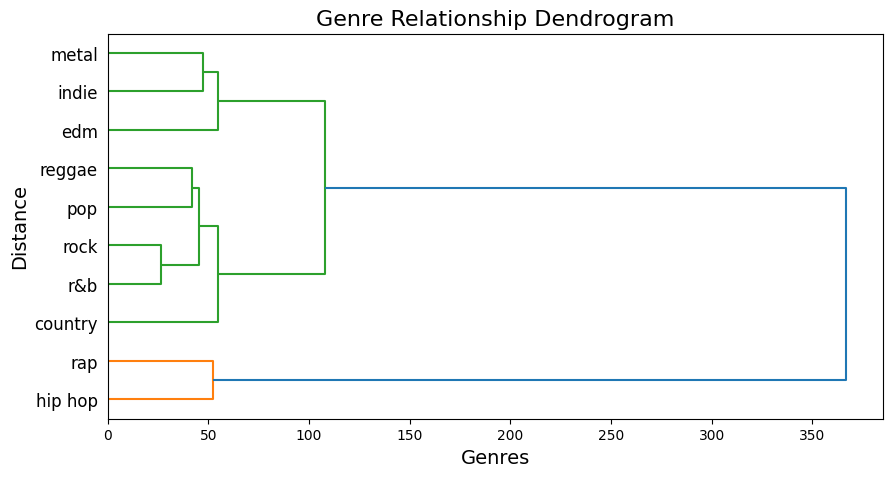

In [16]:
from scipy.cluster.hierarchy import linkage, dendrogram
import matplotlib.pyplot as plt

features = lyrics_features + audio_extracted_features
num_df = df[features].dropna().select_dtypes(include=[np.number])
num_df = pd.concat([num_df, df.genre], axis=1)
genre_features = num_df.groupby("genre").mean()
linkage_matrix = linkage(genre_features, method='ward')

plt.figure(figsize=(10, 5))  # Adjust width and height
dendrogram(linkage_matrix, labels=genre_features.index,orientation='right')
plt.title("Genre Relationship Dendrogram", fontsize=16)
plt.xlabel("Genres", fontsize=14)
plt.ylabel("Distance", fontsize=14)
plt.savefig(os.path.join(ROOT_PATH, 'document', 'img', 'genres_dendrogram.png'), bbox_inches='tight')
plt.show()


This heatmap highlights the distinctivness of rap and hip hop, that are the only two genres that have very little in common with the remaining ones.

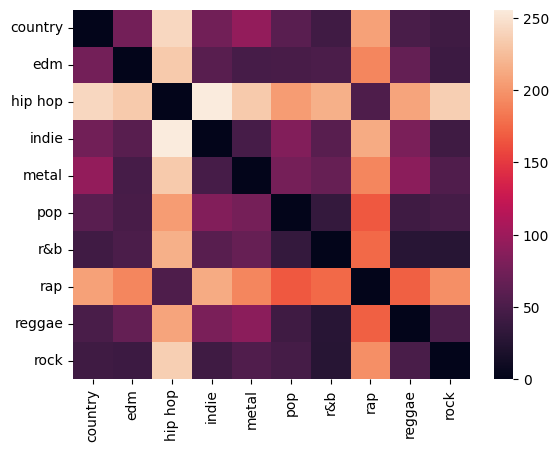

In [17]:
from scipy.spatial.distance import pdist, squareform
distance_matrix = squareform(pdist(genre_features, metric='euclidean'))
sns.heatmap(distance_matrix, xticklabels=genre_features.index, yticklabels=genre_features.index)#, cmap="viridis")
plt.savefig(os.path.join(ROOT_PATH, 'document', 'img', 'genres_similarity_heatmap.png'), bbox_inches='tight')

Here we can see genre characteristics. 

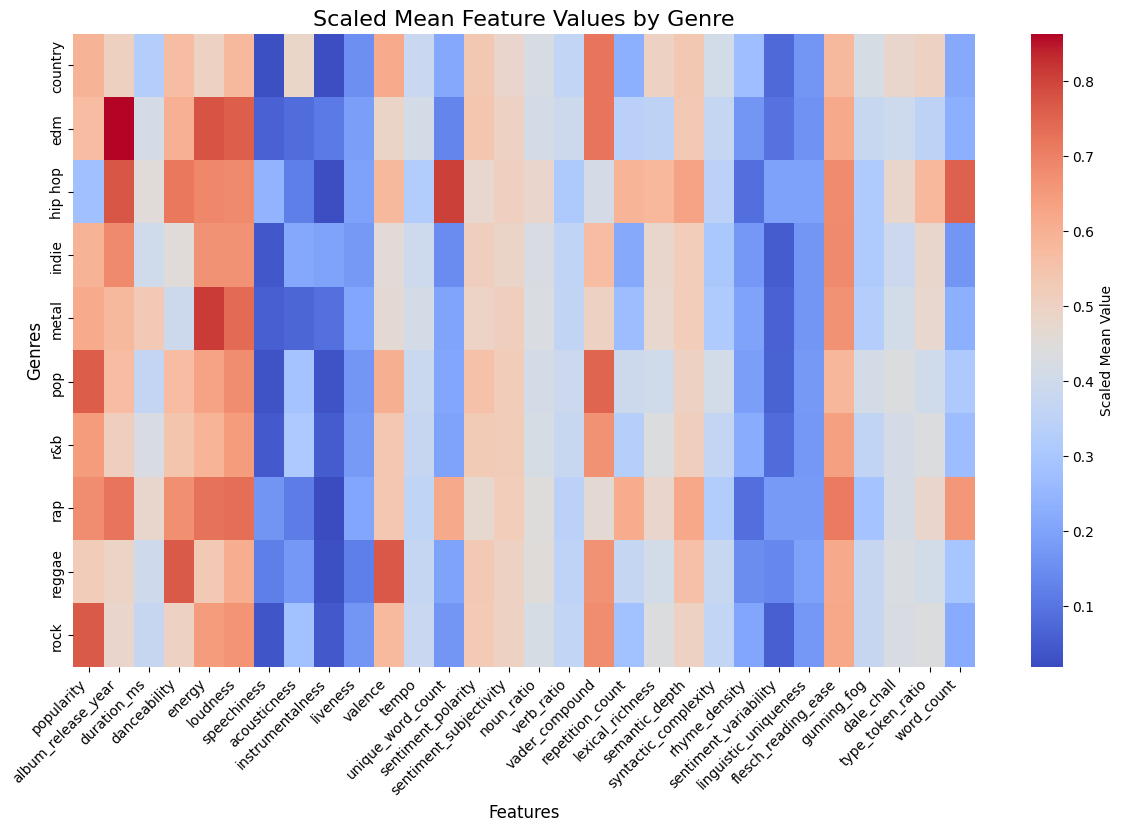

In [50]:
top_5_features_df, fig = analyze_genre_features(df, spotify_features + lyrics_features)
fig.set_figwidth(12)
fig.set_figheight(8)
fig

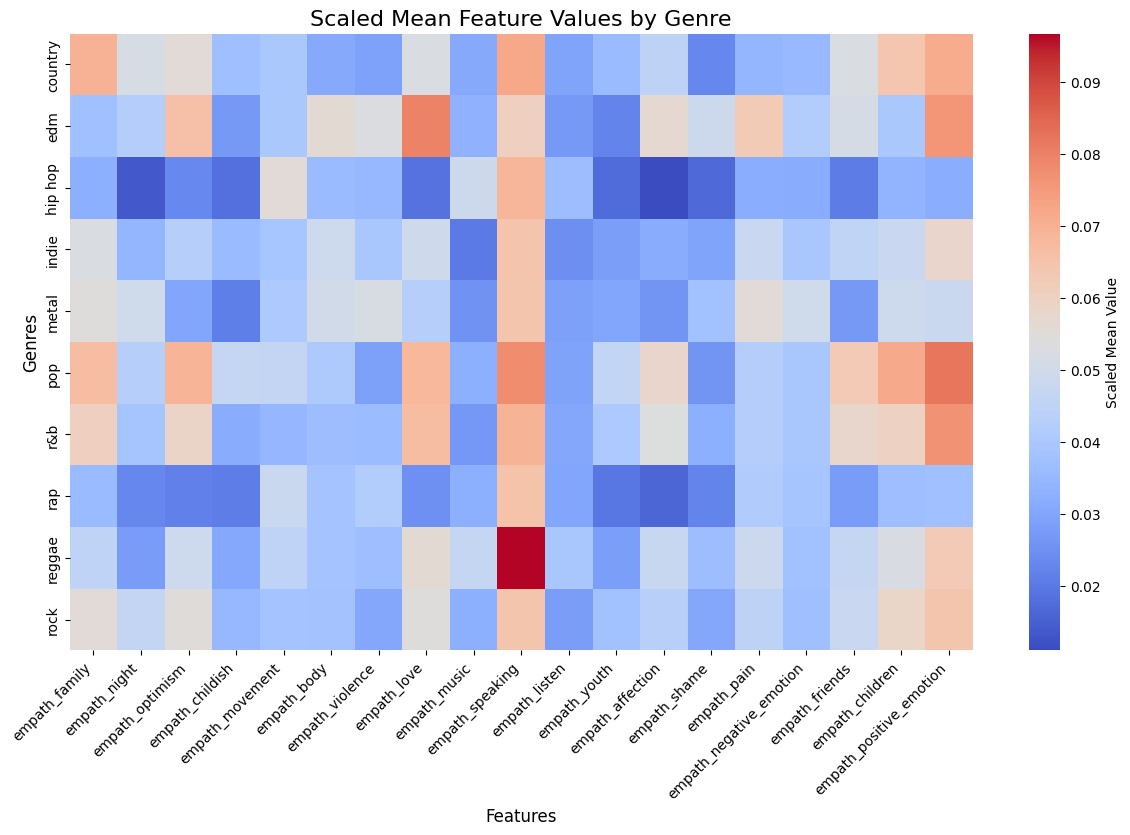

In [94]:
top_5_features_df, fig = analyze_genre_features(df, empath_features)
fig.set_figwidth(12)
fig.set_figheight(8)
fig.savefig(os.path.join(ROOT_PATH, 'document', 'img', 'heatmap_of_empath.png'))
fig

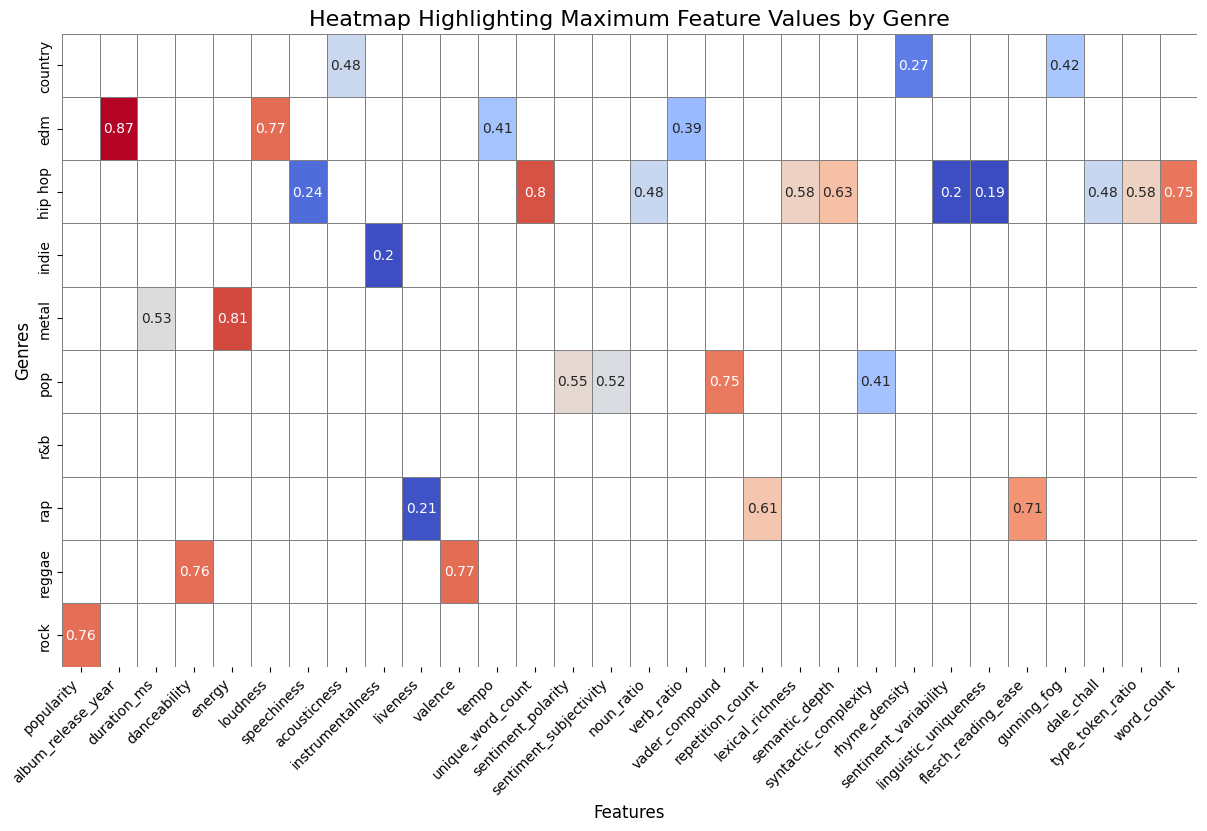

In [96]:
fig = plot_feature_max_by_genre_heatmap(df, spotify_features + lyrics_features)
fig.set_figwidth(12)
fig.set_figheight(8)
fig.savefig(os.path.join(ROOT_PATH, 'document', 'img', 'heatmap_max_feature_values_by_genre.png'))
fig

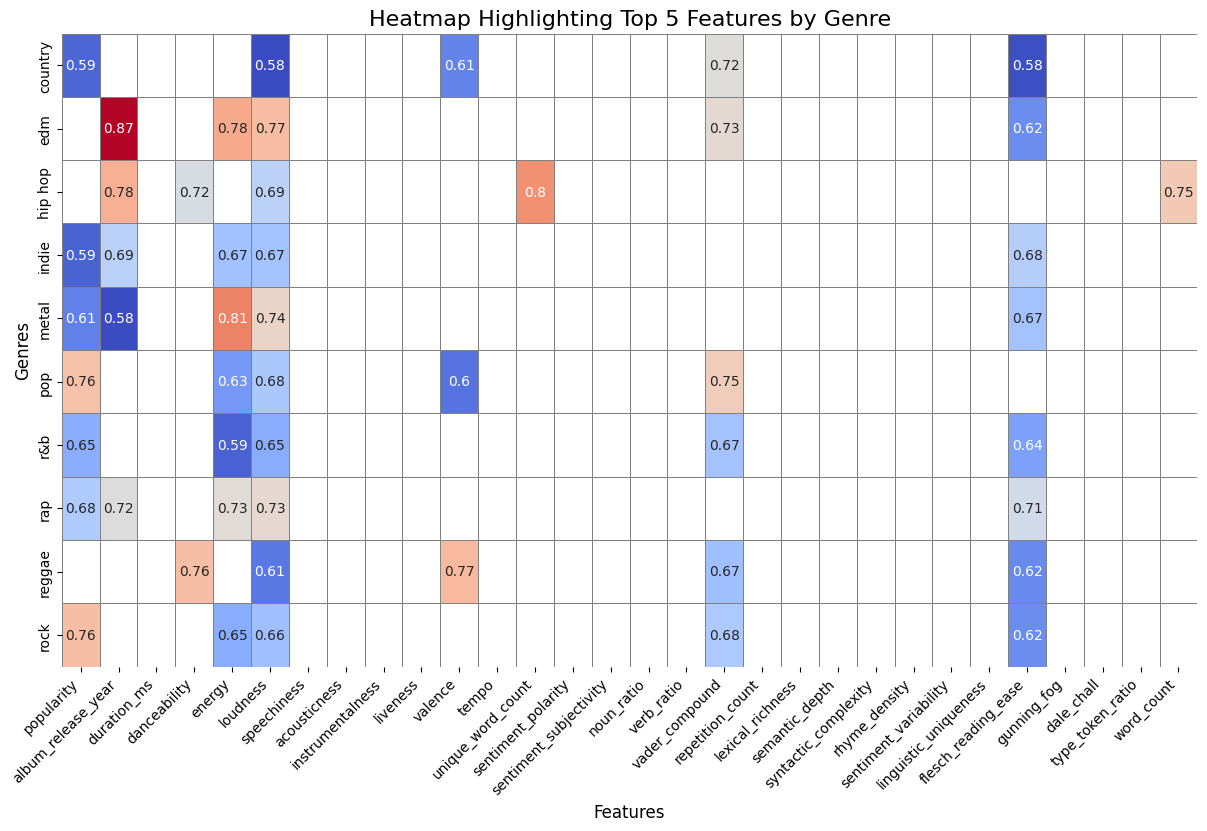

In [97]:
fig = plot_top_features_per_genre_heatmap(df, spotify_features + lyrics_features)
fig.set_figwidth(12)
fig.set_figheight(8)
fig.savefig(os.path.join(ROOT_PATH, 'document', 'img', 'heatmap_top_feature_values_by_genre.png'))
fig

## Lyrical Similarity based on lyrics embeddings

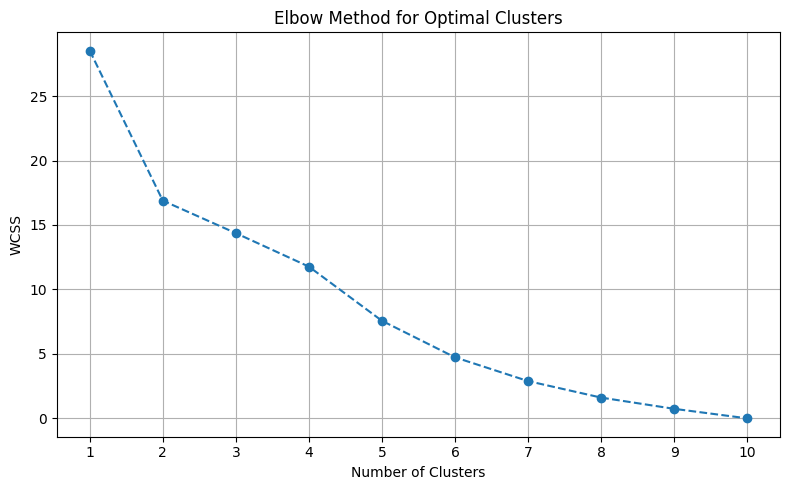

In [61]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.metrics import pairwise_distances
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from scipy.spatial import ConvexHull
import numpy as np

emb_df = df.copy()
emb_df[tfidf_features] = StandardScaler().fit_transform(emb_df[tfidf_features])
emb_df[w2v_features] = StandardScaler().fit_transform(emb_df[w2v_features])

# Step 1: Preprocess and Scale Features
emb_df = df.copy()
emb_df[tfidf_features] = StandardScaler().fit_transform(emb_df[tfidf_features])
emb_df[w2v_features] = StandardScaler().fit_transform(emb_df[w2v_features])

# Step 2: Calculate mean embeddings for each genre
mean_w2v_df = emb_df.groupby('genre')[tfidf_features + w2v_features].mean()

# Step 3: Perform Clustering on the Mean Embeddings
wcss = []
for k in range(1, 11):  # Testing for 1 to 10 clusters
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(mean_w2v_df)  # Clustering in the original embedding space
    wcss.append(kmeans.inertia_)

# Step 4: Plot the Elbow Curve
plt.figure(figsize=(8, 5))
plt.plot(range(1, 11), wcss, marker='o', linestyle='--')
plt.title('Elbow Method for Optimal Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.xticks(range(1, 11))
plt.grid(True)
plt.tight_layout()
plt.show()

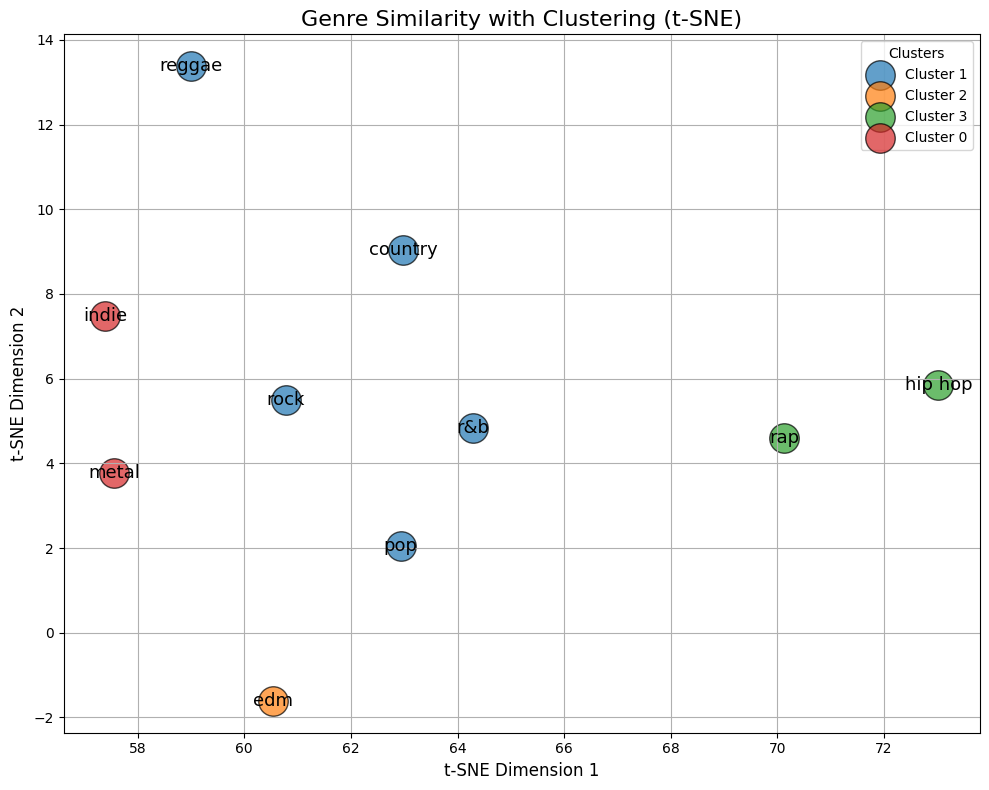

In [63]:
# Step 5: Select Optimal Clusters (e.g., 4 clusters based on the elbow method)
optimal_clusters = 4
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
mean_w2v_df['cluster'] = kmeans.fit_predict(mean_w2v_df)

# Step 6: Apply t-SNE for Dimensionality Reduction
distance_matrix = pairwise_distances(mean_w2v_df.drop(columns=['cluster']), metric='euclidean')
tsne = TSNE(n_components=2, metric='precomputed', perplexity=5, init='random', random_state=42)
genre_coordinates = tsne.fit_transform(distance_matrix)

# Convert t-SNE output to a DataFrame
genre_coords_df = pd.DataFrame(genre_coordinates, index=mean_w2v_df.index, columns=['x', 'y'])
genre_coords_df['cluster'] = mean_w2v_df['cluster']

# Step 7: Plot the t-SNE Scatter Plot with Clusters
plt.figure(figsize=(10, 8))
for cluster_id in genre_coords_df['cluster'].unique():
    cluster_points = genre_coords_df[genre_coords_df['cluster'] == cluster_id]
    plt.scatter(
        cluster_points['x'], 
        cluster_points['y'], 
        label=f'Cluster {cluster_id}', 
        s=450,  # Larger size for points
        alpha=0.7,
        edgecolors='k'
    )

# Add genre labels
for genre, (x, y) in genre_coords_df[['x', 'y']].iterrows():
    plt.text(x, y, genre, fontsize=13, ha='center', va='center')

# Final Plot Settings
plt.title('Genre Similarity with Clustering (t-SNE)', fontsize=16)
plt.xlabel('t-SNE Dimension 1', fontsize=12)
plt.ylabel('t-SNE Dimension 2', fontsize=12)
plt.legend(loc='best', bbox_to_anchor=(1, 1), title="Clusters")
plt.grid(True)
plt.tight_layout()
plt.savefig(os.path.join(ROOT_PATH, 'document', 'img', 'tsne_genres.png'))
plt.show()